In [107]:
import os

import pickle

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets.vision import VisionDataset

from sklearn.manifold import TSNE

from datasets import BadNetsDataset, WaNetDataset, SIGDataset
from simclr import SimClrBackbone



In [108]:
device = "cuda"

In [109]:
RUN_TSNE = False
RUN_KNN = True
RUN_ENERGY = False
RUN_LOGREG = False

SIMCLR_MODEL_NAME = "WaNet-SimCLR.pt"

DATASET = "wanet"
TRAIN = False

if DATASET == "badnets":
    TARGET_CLASS = 1
    DATASET_NAME = "BadNets"
elif DATASET == "wanet":
    TARGET_CLASS = 0
    DATASET_NAME = "WaNet"
elif DATASET == "sig":
    TARGET_CLASS = 1
    DATASET_NAME = "SIG"
# add option for clean
else:
    raise Exception("Invalid dataset")

## Poison dataset

In [110]:
def prepare_poison_dataset() -> VisionDataset:
    clean_dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=TRAIN)

    if DATASET == "badnets":
        poison_dataset = BadNetsDataset(clean_dataset, TARGET_CLASS, "triggers/trigger_10.png", seed=1)
    elif DATASET == "wanet":
        poison_dataset = WaNetDataset(clean_dataset, TARGET_CLASS, seed=1)
    elif DATASET == "sig":
        poison_dataset = SIGDataset(clean_dataset, TARGET_CLASS, 20, 6, seed=1)
    else:
        raise Exception("Invalid dataset")

    poison_indices = np.array([poison_dataset.is_poison(i) for i in range(len(poison_dataset))])

    return poison_dataset, poison_indices

dataset, poison_indices = prepare_poison_dataset()
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## Load SimCLR model

In [111]:
def load_model(simclr_model_name: str) -> SimClrBackbone:
    model = SimClrBackbone()
    out = os.path.join('./saved_models/', simclr_model_name)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(device)
    model.eval()
    return model

model = load_model(SIMCLR_MODEL_NAME)

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Extract features for all images

In [112]:
def extract_simclr_features(model: SimClrBackbone, dataset: VisionDataset):

    simclr_feature_size = 128
    num_examples = len(dataset)

    features = np.zeros((num_examples, simclr_feature_size))
    labels_poison = np.zeros((num_examples))
    labels_true = np.zeros((num_examples))

    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        features[i*batch_size : i*batch_size+len(features_batch)] = features_batch
        labels_poison[i*batch_size : i*batch_size+len(labels_batch_poison)] = labels_batch_poison.long()
        labels_true[i*batch_size : i*batch_size+len(labels_batch_true)] = labels_batch_true.long()

    labels_poison = labels_poison.astype(int)
    labels_true = labels_poison.astype(int)

    return features, labels_poison, labels_true

features, labels_poison, labels_true = extract_simclr_features(model, dataset)
num_classes = int(max(labels_poison).item())

## Plot t-SNE features

In [113]:
def plot_tsne(features: np.array, labels: np.array, poison_indices: np.array, subset_size: int = 10000) -> None:
    # label poison examples as 10
    labels = labels[:]
    labels[poison_indices] = 10

    # Plot only a subset
    features_subset = features[:subset_size]
    labels_subset = labels[:subset_size]
        
    tsne = TSNE(n_components = 2, perplexity = 50)
    tsne_features = tsne.fit_transform(features_subset)

    for i in range(num_classes):
        plt.scatter(tsne_features[labels_subset==i,1], tsne_features[labels_subset==i,0])
    plt.scatter(tsne_features[labels_subset==10,1], tsne_features[labels_subset==10,0], c = "black", marker= "x")

    plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()


if RUN_TSNE:
    plot_tsne(features, labels_poison, poison_indices)

## kNN clean

In [114]:
def evaluate_cleanse(labels_predicted: np.array, labels_poison: np.array, poison_indices: np.array):
    poison_predicted = labels_predicted != labels_poison

    tp = (poison_indices & poison_predicted).sum()
    fp = (np.invert(poison_indices) & poison_predicted).sum()
    fn = (poison_indices & np.invert(poison_predicted)).sum()
    tn = (np.invert(poison_indices) & np.invert(poison_predicted)).sum()

    fnr = fn/(fn+tp) if fn+tp!=0 else 0
    tnr = tn/(tn+fp) if tn+fp!=0 else 0
    poison_rate = fn/(fn+tn) if fn+tn!=0 else 0

    print(f"{tp} \t {fp}")
    print(f"{fn} \t {tn}")
    print()
    print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
    print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
    print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")

def save_predicted_labels(labels_predicted: np.array, save_name: str):
    with open(f"./cleansed_labels/{save_name}.pkl", "wb") as f:
        pickle.dump(labels_predicted, f)

In [115]:
from sklearn.neighbors import KNeighborsClassifier

def knn_cleanse(features: np.array, labels_poison: np.array, num_classes: int) -> np.array:
    
    examples_per_class = len(features) / num_classes
    knn = KNeighborsClassifier(n_neighbors=int(examples_per_class/2))
    knn.fit(features, labels_poison)
    labels_predicted = knn.predict(features)

    return labels_predicted

if RUN_KNN:
    labels_predicted_knn = knn_cleanse(features, labels_poison, num_classes)
    evaluate_cleanse(labels_predicted_knn, labels_poison, poison_indices)

    save_name = f"__NEW__{DATASET_NAME}-kNN-{'train' if TRAIN else 'test'}"
    save_predicted_labels(labels_predicted_knn, save_name)

695 	 3116
305 	 5884

Percentage of poisoned images (out of all poisoned) kept:  30.50%
Percentage of clean images (out of all clean) kept:  65.38%
Percentage of remaining poisoned images (out of all remaining):  4.93%


------------------------------------

CIFAR-10 train \
BadNets 

    4905 	 9481
    95 	 35519
    Percentage of poisoned images (out of all poisoned) kept:  1.90%
    Percentage of clean images (out of all clean) kept:  78.93%
    Percentage of remaining poisoned images (out of all remaining):  0.27%

CIFAR-10 test \
BadNets 

    960 	 2056
    40 	 6944
    Percentage of poisoned images (out of all poisoned) kept:  4.00%
    Percentage of clean images (out of all clean) kept:  77.16%
    Percentage of remaining poisoned images (out of all remaining):  0.57%

------------------------------------

CIFAR-10 train \
WaNet 

    3975 	 14331
    1025 	 30669
    Percentage of poisoned images (out of all poisoned) kept:  20.50%
    Percentage of clean images (out of all clean) kept:  68.15%
    Percentage of remaining poisoned images (out of all remaining):  3.23%

CIFAR-10 test \
WaNet 

    712 	 3058
    288 	 5942
    Percentage of poisoned images (out of all poisoned) kept:  28.80%
    Percentage of clean images (out of all clean) kept:  66.02%
    Percentage of remaining poisoned images (out of all remaining):  4.62%

------------------------------------

CIFAR-10 test \
SIG

    0 	 9195
    500 	 40305
    Percentage of poisoned images (out of all poisoned) kept:  100.00%
    Percentage of clean images (out of all clean) kept:  81.42%
    Percentage of remaining poisoned images (out of all remaining):  1.23%

## Energy clean

In [117]:
class EnergyClassifier():

    def __init__(self, t=1):
        self.t = t

    def fit(self, X, y):
        self.X = X
        self.y = y
        
        self.C = int(np.max(y))
        self.Ic = {c:[i for i in range(len(y)) if y[i]==c] for c in range(self.C)}
        
    def predict_index(self, i):

        # consider improving with numpy

        xi = self.X[i]

        exp_all = np.exp([xi*self.X[k]/self.t for k in range(len(self.X))])
        sum_exp_all_except_xi = np.sum([exp_all[k] for k in range(len(self.X)) if k!=i])
        mean_exp_c = [np.mean([exp_all[k] for k in self.Ic[c] if k!=i]) for c in range(self.C)]
    
        Scs = mean_exp_c / sum_exp_all_except_xi
        return np.argmax(Scs)

if DATASET == "badnets":
    T = 100
elif DATASET == "wanet":
    T = 10
elif DATASET == "sig":
    T = 1
else:
    raise Exception("Invalid dataset")

if RUN_ENERGY:
    energy = EnergyClassifier(t=T)
    energy.fit(features, labels_poison)

In [118]:
if RUN_ENERGY:
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    predicted_labels = []

    for i in range(len(dataset)):
        poison_label = labels_poison[i]
        true_label = labels_true[i]
        predicted_label = energy.predict_index(i)

        predicted_labels.append(predicted_label)

        true_poison = poison_dataset.is_poison(i)
        predicted_poison = poison_label != predicted_label

        if true_poison and predicted_poison:
            tp += 1
        elif not true_poison and predicted_poison:
            fp += 1
        elif true_poison and not predicted_poison:
            fn += 1
        else:
            tn += 1

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"{i} / {len(dataset)}")
            print(f"\t {tp} \t {fp}")
            print(f"\t {fn} \t {tn}")

            fnr = fn/(fn+tp) if fn+tp!=0 else 0
            tnr = tn/(tn+fp) if tn+fp!=0 else 0
            poison_rate = fn/(fn+tn) if fn+tn!=0 else 0
            print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
            print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
            print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")


    clear_output(wait=True)
    print(f"{len(dataset)} / {len(dataset)}")
    print(f"\t {tp} \t {fp}")
    print(f"\t {fn} \t {tn}")

    fnr = fn/(fn+tp) if fn+tp!=0 else 0
    tnr = tn/(tn+fp) if tn+fp!=0 else 0
    poison_rate = fn/(fn+tn) if fn+tn!=0 else 0
    print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
    print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
    print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")

CIFAR-10 train \
BadNets

	50000 / 50000
		4618 	 12732
		382 	 32268
	Percentage of poisoned images (out of all poisoned) kept:  7.64%
	Percentage of clean images (out of all clean) kept:  71.71%
	Percentage of remaining poisoned images (out of all remaining):  1.17%

CIFAR-10 test \
BadNets

	10000 / 10000
		920 	 2585
		80 	 6415
	Percentage of poisoned images (out of all poisoned) kept:  8.00%
	Percentage of clean images (out of all clean) kept:  71.28%
	Percentage of remaining poisoned images (out of all remaining):  1.23%

--------------------------------------------------------------------------------

CIFAR-10 train \
WaNet

	50000 / 50000
		4725 	 14096
		275 	 30904
	Percentage of poisoned images (out of all poisoned) kept:  5.50%
	Percentage of clean images (out of all clean) kept:  68.68%
	Percentage of remaining poisoned images (out of all remaining):  0.88%

CIFAR-10 test \
WaNet

	10000 / 10000
		951 	 2851
		49 	 6149
	Percentage of poisoned images (out of all poisoned) kept:  4.90%
	Percentage of clean images (out of all clean) kept:  68.32%
	Percentage of remaining poisoned images (out of all remaining):  0.79%

--------------------------------------------------------------------------------

CIFAR-10 train \
SIG

	50000 / 50000
		2 	 15777
		498 	 33723
	Percentage of poisoned images (out of all poisoned) kept:  99.60%
	Percentage of clean images (out of all clean) kept:  68.13%
	Percentage of remaining poisoned images (out of all remaining):  1.46%

In [119]:
if RUN_ENERGY:

    save_name = f"__NEW__{DATASET_NAME}-Energy-{'train' if TRAIN else 'test'}"

    with open(f"./cleansed_labels/{save_name}.pkl", "wb") as f:
        pickle.dump(predicted_labels, f)

## LogReg clean

In [120]:
class LogReg(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(LogReg, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
    def forward(self, x):
        return torch.softmax(self.linear(x), dim=1)

In [121]:
class SimClrFeaturesDataset(VisionDataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    def __len__(self):
        return len(self.features)

In [122]:
if RUN_LOGREG:
    
    BATCH_SIZE = 1024
    NUM_MODELS = 10
    EPOCHS = 60

    classifications = np.zeros((NUM_MODELS, len(features)))

    for num_model in range(NUM_MODELS):
        print(f"Learning logistic regression model {num_model+1}/{NUM_MODELS}")
        simclr_features_dataset = SimClrFeaturesDataset(features, labels_poison)
        dataloader = DataLoader(dataset=simclr_features_dataset, batch_size=BATCH_SIZE, shuffle=True) 
        model = LogReg(128, 10)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-1)
        criterion = torch.nn.CrossEntropyLoss()
        
        # train
        for epoch in range(EPOCHS):
            correct = 0
            for i, (batch_features, batch_labels) in enumerate(dataloader):
                batch_features, batch_labels = batch_features.float(), batch_labels.long()

                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == batch_labels).sum()
            accuracy = 100 * (correct.item()) / len(simclr_features_dataset)
        print(f"Accuracy: {accuracy}")

        # get model classifications
        dataloader = DataLoader(dataset=simclr_features_dataset, batch_size=BATCH_SIZE, shuffle=False) 
        for i, (batch_features, batch_labels) in enumerate(dataloader):
            batch_features, batch_labels = batch_features.float(), batch_labels.long()

            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.numpy()
            classifications[num_model, (i*BATCH_SIZE):(i*BATCH_SIZE+len(predicted))] = predicted


In [123]:
labels_poison_repeated = np.tile(labels_poison, (NUM_MODELS,1))
misclassifications = np.sum(classifications != labels_poison_repeated, axis=0)

poisoned_vector = np.array([poison_dataset.is_poison(i) for i in range(len(labels_poison))])

misclassifications_poisoned = misclassifications[poisoned_vector]
misclassifications_clean = misclassifications[np.invert(poisoned_vector)]

# print(misclassifications_poisoned.shape)
# print(misclassifications_clean.shape)

# print(np.average(misclassifications_poisoned))
# print(np.average(misclassifications_clean))

bins = np.linspace(0, np.max(misclassifications), np.max(misclassifications))
plt.hist(misclassifications_clean, bins, alpha=0.5, label='clean')
plt.hist(misclassifications_poisoned, bins, alpha=0.5, label='poisoned')
plt.legend(loc='upper right')
plt.show()

NameError: name 'NUM_MODELS' is not defined

(50000,)
(5000,)
(500,)
(4500,)


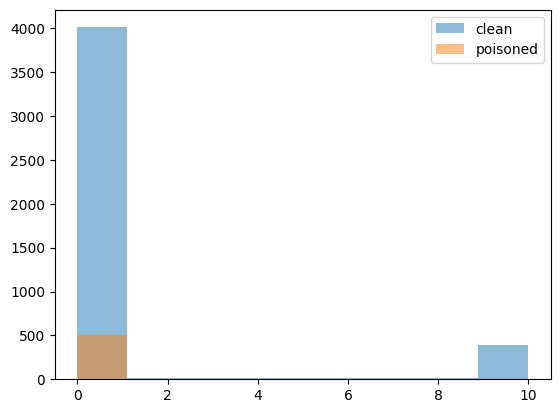

In [ ]:
class_num = 1

misclassifications_class = misclassifications[labels_poison == class_num]
misclassifications_class_poisoned = misclassifications[np.logical_and(labels_poison == class_num, poisoned_vector)]
misclassifications_class_clean = misclassifications[np.logical_and(labels_poison == class_num, np.invert(poisoned_vector))]

print((labels_poison == class_num & np.invert(poisoned_vector)).shape)
print(misclassifications_class.shape)
print(misclassifications_class_poisoned.shape)
print(misclassifications_class_clean.shape)

bins = np.linspace(0, np.max(misclassifications_class), np.max(misclassifications_class))
plt.hist(misclassifications_class_clean, bins, alpha=0.5, label='clean')
plt.hist(misclassifications_class_poisoned, bins, alpha=0.5, label='poisoned')
plt.legend(loc='upper right')
plt.show()

In [ ]:
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(tsne_features[:,0]), np.max(tsne_features[:,0])
X2d_ymin, X2d_ymax = np.min(tsne_features[:,1]), np.max(tsne_features[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
outputs = model(torch.tensor(features_subset).float())
_, predicted = torch.max(outputs.data, 1)
predicted = predicted.detach().numpy()
background_model = KNeighborsClassifier(n_neighbors=1).fit(tsne_features, predicted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=0,vmax=10)

plt.contourf(xx, yy, voronoiBackground, norm=norm, cmap ="jet")
#plt.scatter(tsne_features[:,0], tsne_features[:,1], c=predicted, norm=norm, cmap ="jet")
plt.show()

NameError: name 'KNeighborsClassifier' is not defined